<a href="https://colab.research.google.com/github/prometheus404/AMD_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### DOWNLOAD DATASET #####
from IPython.display import clear_output
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gsimonx37/letterboxd
!unzip /content/letterboxd.zip -d /content/letterbox/
clear_output()
############################

In [2]:
########### SPARK CONTEXT #####################
import pandas as pd
import itertools
from tqdm import tqdm
import time

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

sc = spark.sparkContext
###############################################

In [8]:
N_BASKETS = 0       #0 for full dataset
SPARK_CREATION = False  #initialize the RDD using spark instead of pandas to read the file

############## BASKET CREATION ################
if(SPARK_CREATION == False):
  actors = pd.read_csv("letterbox/actors.csv")
  actors = actors
  baskets = actors.groupby("id")["name"].apply(list)
  if(N_BASKETS > 0):
    baskets = baskets.sample(N_BASKETS, random_state = 42)

  print("number of baskets: " + str(len(baskets)))
  print("biggest basket: " + str(baskets.map(len).max()))
  print(baskets)
  baskets_RDD = sc.parallelize(baskets).cache()
else:
  RDD = sc.textFile("letterbox/actors.csv").map(lambda x: tuple(x.split(',')[:2])) #read from csv and split
  RDD = RDD.filter(lambda x: x != ('id','name')) #filter out the header
  RDD = RDD.groupByKey().mapValues(list).values()
  if(N_BASKETS > 0):
    baskets_RDD = RDD.sample(False, N_BASKETS, seed = 42).cache() #fixed but different for each iteration seed
  else:
    baskets_RDD = RDD.cache()
##############################################

number of baskets: 634302
biggest basket: 555
id
1000001    [Margot Robbie, Ryan Gosling, America Ferrera,...
1000002    [Song Kang-ho, Lee Sun-kyun, Cho Yeo-jeong, Ch...
1000003    [Michelle Yeoh, Ke Huy Quan, Stephanie Hsu, Ja...
1000004    [Edward Norton, Brad Pitt, Helena Bonham Carte...
1000005    [Ryan Gosling, Emma Stone, John Legend, Rosema...
                                 ...                        
1941559                                                 [黑灯]
1941563    [Kara Wai Ying-Hung, Zhang Youhao, Pan Binlong...
1941589                                                [王军锋]
1941596    [Nick Cheung, Ethan Juan, Sandrine Pinna, Marc...
1941597                      [Hiroshi Mikami, Keiko Oginome]
Name: name, Length: 634302, dtype: object


In [10]:
## APRIORI
def apriori(chunk, s, tot_bsk):

  n_bsk = 0 # number of baskets in chunk used to calculate support
#  trsl = dict() # using a translation could be better for the combination step
  count = dict() # should be relatively efficient since is a hash table

#
#  def translate(e, dic):
#    try:
#      return dic[e]
#    except KeyError:
#      dic[e] = len(dic)+1
#      return dic[e]
  def incr(e,dic):
    try:
      dic[e] += 1;
    except KeyError:
      dic[e] = 1

  chunk = list(chunk) # to avoid consuming after first pass
  ### first pass
  for bsk in chunk:
    n_bsk += 1;
    #elements = [translate(x,trsl) for x in bsk]
    for b in bsk:
      incr(b,count)

  ### filter
  to_del = []
  frequent = []
  for c in count:
    if count[c] >= s* n_bsk/tot_bsk:
      frequent.append(c)

  k = 2
  while len(frequent) > 0:
    count = dict()

    for bsk in tqdm(chunk):
      #filter only members of C_k
      filtered = set()
      for b in bsk:
        for f in frequent:
          if k== 2 and b == f:
            filtered.add(b)
            break;
          if k > 2 and b in f:
          #if b in f:
            filtered.add(b)
            break;
      bsk = list(filtered)
      bsk.sort()
      for tpl in itertools.combinations(bsk, k):
          incr(tuple(tpl), count)

    frequent = []
    for c in count:
      if count[c] >= s * n_bsk/tot_bsk:
        frequent.append(c)
        yield(c,1)
    k+=1


In [6]:
## SON
def son(rdd,s,tot):
  def chunk_support(chunk,itemset):
    def incr(e,dic):
      try:
        dic[e] += 1;
      except KeyError:
        dic[e] = 1

    count = dict()
    for bsk in tqdm(chunk):
      for i in itemset:
        flag = True
        for e in i:
          if e not in bsk:
            flag = False
            break
        if flag:
          incr(i,count)
    for c in count:
      yield (c,count[c])

  t= time.time()
  #FIRST STEP
  candidates = rdd.mapPartitions(lambda x: apriori(x,s,tot)).reduceByKey(lambda a,b: a).keys().collect()
  #SECOND STEP
  out =  rdd.mapPartitions(lambda x: chunk_support(x, candidates)).reduceByKey(lambda a,b: a+b).filter(lambda a: a[1] >= s).keys().collect()
  t = time.time() - t
  return (t,out)


In [11]:
son(baskets_RDD, 100, len(baskets))

(6057.770021677017,
 [('Bess Flowers', 'Harold Miller'),
  ('George Harrison', 'John Lennon'),
  ('George Harrison', 'Paul McCartney'),
  ('John Lennon', 'Paul McCartney'),
  ('George Harrison', 'John Lennon', 'Ringo Starr'),
  ('George Harrison', 'Paul McCartney', 'Ringo Starr'),
  ('John Lennon', 'Paul McCartney', 'Ringo Starr'),
  ('Eddie Vedder', 'Stone Gossard'),
  ('Jeff Ament', 'Matt Cameron'),
  ('Eddie Vedder', 'Jeff Ament', 'Stone Gossard'),
  ('Eddie Vedder', 'Matt Cameron', 'Stone Gossard'),
  ('Eddie Vedder', 'Jeff Ament', 'Matt Cameron', 'Stone Gossard'),
  ('Hitoshi Ozawa', 'Yoshiyuki Yamaguchi'),
  ('James Hetfield', 'Kirk Hammett'),
  ('James Hetfield', 'Lars Ulrich'),
  ('Kirk Hammett', 'Lars Ulrich'),
  ('Jack Mercer', 'Mae Questel'),
  ('Jack Mercer', 'Jackson Beck'),
  ('Jeff Ament', 'Mike McCready'),
  ('Matt Cameron', 'Mike McCready'),
  ('Eddie Vedder', 'Mike McCready', 'Stone Gossard'),
  ('Jeff Ament', 'Matt Cameron', 'Mike McCready'),
  ('Eddie Vedder', 'Jeff

In [ ]:
# NOTE it's important to change seed even with different fractions
# tmp2 = sc.parallelize(range(0,1000))
# print(tmp2.sample(False,fraction=0.001, seed = 42).collect()) # output: [115,385]
# print(tmp2.sample(False,fraction=0.002, seed = 42).collect()) # output: [115, 359, 385]
# print(tmp2.sample(False,fraction=0.003, seed = 42).collect()) # output: [115, 359, 385]

[115, 385]
[115, 359, 385]
[115, 359, 385]


In [ ]:
#RDD = sc.textFile("letterbox/actors.csv").map(lambda x: tuple(x.split(','))) #read from csv and split
#RDD = RDD.filter(lambda x: x != ('id','name')) #filter out the header
##construct dictionary for translation
#RDD_dict = RDD.sortBy(lambda x: x[1]).values().distinct().zipWithIndex() # not zipWithUniquenId since we could need gap-less id
#RDD = RDD.map(lambda x: (x[1],x[0])) #invert keys with values in order to perform the join over the actor name
#RDD = RDD.join(RDD_dict).map(lambda x: (x[1][0],x[1][1])) #join and use as key the movie and as value the actor id
#RDD = RDD.groupByKey().mapValues(list).values().cache() #create the baskets and cache them

##sample RDD and save the results
#for i in tqdm(range(10000, 60000, 10000)):
#  sampled_RDD = RDD.takeSample(False, i, seed = i) #fixed but different for each iteration seed
#  #sampled_RDD.saveAsTextFile("./rdd-"+str(i)+".csv")
#  print(son(sampled_RDD,15,sampled_RDD.count()))
#recover from memory
#for i in tqdm(range(10000,60000,10000)):
#  x = sc.textFile("rdd-"+str(i)+".csv/")
#  x = x.map(lambda s: s[1:-1].split(',')).map(lambda s: [int(i) for i in s])
#  son(x,6,i)

# Time and different dataset size

In [ ]:
actors = pd.read_csv("letterbox/actors.csv")
actors = actors
baskets_full = actors.groupby("id")["name"].apply(list)
r = range(1,10)
S = 6
step = 5000

In [ ]:
#TIME WITH DIFFERENT DATASET SIZE APRIORI
apriori_results = []
apriori_times = []
for i in r:
  baskets = baskets_full.sample(i*step, random_state = i)
  #RDD = sc.parallelize(baskets)
  result = []
  t = time.time()
  for i,_ in apriori(baskets,S,i*step):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 45000/45000 [00:00<00:00, 185506.41it/s]


In [ ]:
# TIME WITH DIFFERENT DATASET SIZE SON
son_results = []
son_times = []
for i in r:
  baskets = baskets_full.sample(i*step, random_state = i)
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,i*step)
  son_results.append(result)
  son_times.append(t)

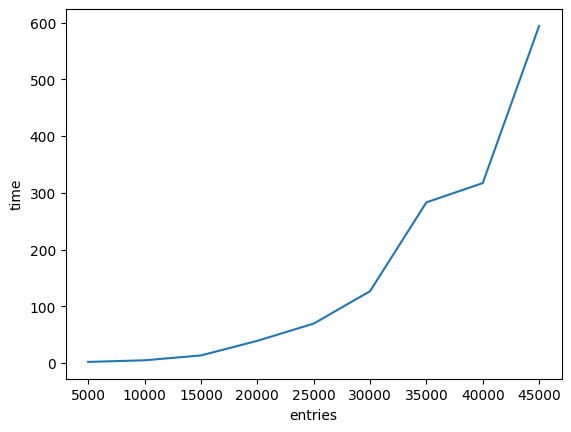

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(list([step*x for x in r]), apriori_times)
plt.plot(list([step*x for x in r]), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('entries')
plt.show()

In [ ]:
# NUMBER OF FREQUENT ITEMSETS FOR EACH SIZE
def itemset_size(itemsets):
  out = []
  for s in itemsets:
    tmp = []
    for i in range(2,8):
      n = len([x for x in s if len(x) == i])
      if n == 0:
        break
      tmp.append((i,n))
    out.append(tmp)
  return out

sz = itemset_size(apriori_results)
for i in r:
  print('size ' + str(i * step) + ': ')
  for e in sz[i-1]:
    print(str(e[0])+'-ples: ' + str(e[1]))

size 5000: 
size 10000: 
2-ples: 4
3-ples: 1
size 15000: 
2-ples: 6
3-ples: 1
size 20000: 
2-ples: 11
3-ples: 1
size 25000: 
2-ples: 61
3-ples: 26
4-ples: 8
5-ples: 1
size 30000: 
2-ples: 100
3-ples: 32
4-ples: 17
5-ples: 6
6-ples: 1
size 35000: 
2-ples: 198
3-ples: 93
4-ples: 61
5-ples: 28
6-ples: 8
7-ples: 1
size 40000: 
2-ples: 219
3-ples: 65
4-ples: 25
5-ples: 6
6-ples: 1
size 45000: 
2-ples: 299
3-ples: 65
4-ples: 23
5-ples: 6
6-ples: 1


In [ ]:
print(apriori_times)
print(son_times)

[0.1856381893157959, 2.271298408508301, 7.10997462272644, 23.074941396713257, 66.4765739440918, 133.45536708831787, 241.44379496574402, 365.7041611671448, 531.0825428962708]
[1.0585579872131348, 3.629045009613037, 15.35119366645813, 38.14787030220032, 68.71897578239441, 125.11725354194641, 288.3468313217163, 328.16686820983887, 574.5382564067841]


# Time and different suppord threshold

In [ ]:
r = 100000
S = range(10,30,3)
step = 5000
baskets = baskets_full.sample(r, random_state = 42)

In [ ]:
#TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD APRIORI
apriori_results = []
apriori_times = []
for s in S:
  result = []
  t = time.time()
  for i,_ in apriori(baskets,s,r):
    result.append(i)
  apriori_times.append(time.time()-t)
  apriori_results.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 148547.03it/s]


In [ ]:
# TIME WITH DIFFERENT DATASET SUPPORT THRESHOLD SON
son_results = []
son_times = []
RDD = sc.parallelize(baskets)
for s in S:
  t, result = son(RDD,s,r)
  son_results.append(result)
  son_times.append(t)

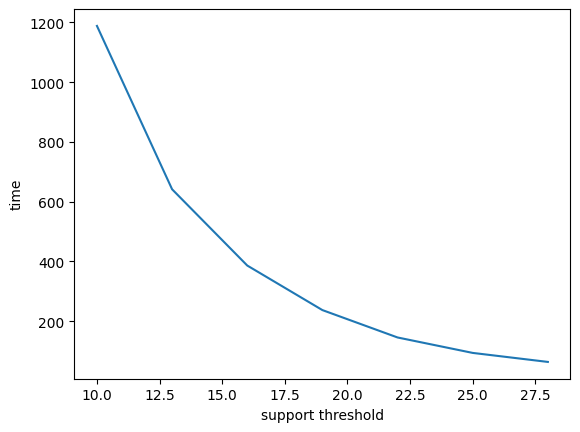

In [ ]:
#plt.plot(list(S), apriori_times)
plt.plot(list(S), son_times)
#plt.legend(['apriori','SON'])
plt.ylabel('time')
plt.xlabel('support threshold')
plt.show()

# Time and different partition number

In [ ]:
r = 100000
S = 25

tp_results = []
tp_times = []
partitions = range(1,6)
for p in partitions:
  spark = SparkSession.builder.master("local["+str(p)+"]").getOrCreate()
  spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
  sc = spark.sparkContext
  RDD = sc.parallelize(baskets)
  t, result = son(RDD,S,r)
  tp_results.append(result)
  tp_times.append(t)



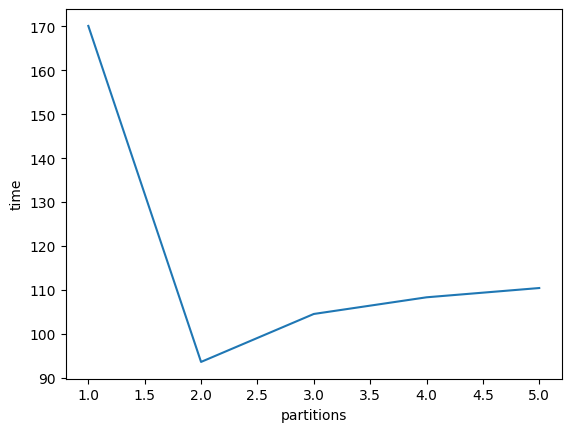

In [ ]:
plt.plot(list(partitions), tp_times)
plt.ylabel('time')
plt.xlabel('partitions')
plt.show()